
# Welcome

Welcome to the Happy Home Seattle house price prediction system. This Jupyter Notebook explores trends in housing prices in the King County, Washington area, and allows the user to predict the price of a house of their choice using a linear regression model.

**The code in this notebook is made up of cells: to run a cell (and thus run the code), make sure it's selected and then click the Run button at the top of the screen.**

### Initial setup
To begin with, we'll first import the Python libraries that we'll need:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Next, we'll import our data. If you're running this notebook manually instead of through Binder, please make sure that `kc_house_data.csv` is in the same directory as this Jupyter Notebook file.

In [2]:
df = pd.read_csv('kc_house_data.csv')

### Descriptive graphs
Now, let's create some graphs that explore the King County, Washington residential real estate market. To begin with, we'll create a simple scatter plot that maps home prices to square footage of living space, along with a best-fit trend line.

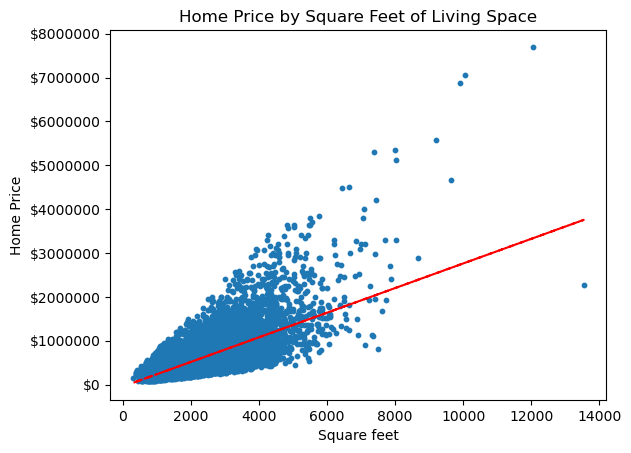

In [3]:
fig, ax = plt.subplots()

x = df['sqft_living']
y = df['price']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.scatter(x, y, 10)
plt.plot(x, p(x), "r--")
plt.xlabel('Square feet')
plt.ylabel('Home Price')
plt.title('Home Price by Square Feet of Living Space')

ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))

plt.show()

As expected, the relationship of a home's price to its livable size is broadly positive. The vast majority of homes tend to be about 5000 square feet or less, and about $2 million or less in value. You can also see a number of extreme outliers towards the top-right of the chart: these will be filtered out in our training data for the prediction model.

Next, let's take a look at how home values relate to the condition that the house is in. Condition in this sense is ranked from 1 through 5, with 1 being the worst and 5 being the best.

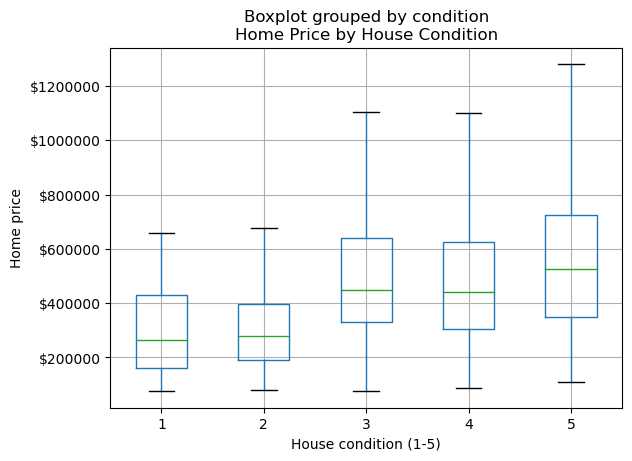

In [4]:
import matplotlib.ticker as ticker

ax = df.boxplot(by='condition', column='price', showfliers=False)
ax.set_title('Home Price by House Condition')
ax.set_xlabel('House condition (1-5)')
ax.set_ylabel('Home price')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%1.0f'))
plt.show()

In general, customers will spend more for a house that is in better condition. However, the distribution of this phenomenon uncovers a key insight: generally, the average home value of a house beyond an average condition (4 and 5) isn't significantly more than that with an average condition (3). This fact may prove that buyers only put value on a house's conditions beyond a certain point.

Finally, we'll create a graph that relates median home values to the year the home was built.

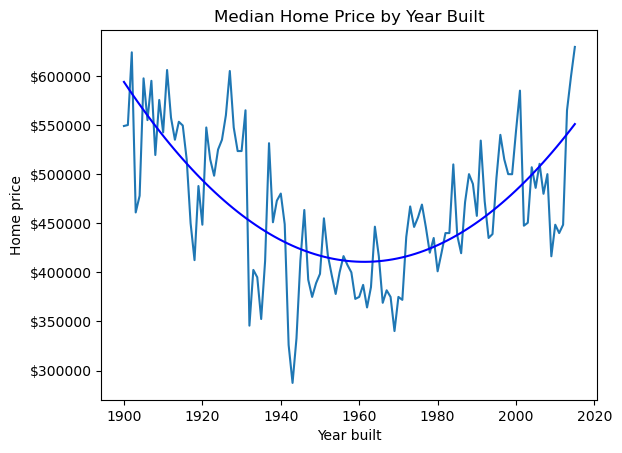

In [5]:
fig, ax = plt.subplots()

median_data = df.groupby('yr_built')['price'].median().reset_index()
polynomial = np.poly1d(np.polyfit(median_data['yr_built'], median_data['price'], 2))

x_curve = np.linspace(min(median_data['yr_built']), max(median_data['yr_built']), 100)
y_curve = polynomial(x_curve)

plt.plot(median_data['yr_built'], median_data['price'])
plt.plot(x_curve, y_curve, color='blue')
plt.title('Median Home Price by Year Built')
plt.xlabel('Year built')
plt.ylabel('Home price')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

This reveals an interesting trend: homes built in the middle of the 20th century seem to have a lower value than those built at the beginning of the 20th century and those built at the turn of the 21st century. This could be related to the suburban housing boom in America correlating to the same time period: it's possible that the influx of housing supply at the time period drove down values.

### Home value prediction model
Now, let's set up our home value prediction model. We'll be using a supervised linear regression model to predict home values based on signficant variables such as bedroom and bathroom count.

We'll first create a dedicated training dataframe using pandas. We then filter out any outliers that lie outside of the interquartile range.

In [6]:
training_df = df

q1 = training_df['price'].quantile(0.25)
q3 = training_df['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filter = (training_df['price'] >= lower_bound) & (training_df['price'] <= upper_bound)
df_cleaned_iqr = training_df.loc[filter]

Once the filtered dataframe is set up, we create a training model based off of it. We drop any variables that we won't be using to make home value predictions.

In [7]:
x = df_cleaned_iqr.drop(columns=['id', 'price', 'date', 'sqft_lot', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'])
y = df_cleaned_iqr[['price']].copy()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=123)
linear_reg_model = LinearRegression(positive = False)
linear_reg_model.fit(X_train,y_train)

y_pred_no_type = linear_reg_model.predict(X_test)

To check the model's accuracy, we perform a mean absolute error on the training model to see the average value the model is off by when predicting a home's value.

In [8]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred_no_type)

121603.46247671009

Finally, the prediction itself. In the input boxes below, enter your house's bedroom and bathroom count, the square feet of living space, the condition the house is in from a scale of 1-5, the year it was built, and the floor count. Hit enter between each input to submit. The prediction model will then return an estimated closing value of that house.

**To run the predictor: click the cell below and click Run at the top of the screen.**

In [ ]:
bedrooms = input("Bedrooms: ")
bathrooms = input("Bathrooms: ")
sqft = input("Square feet of living space: ")
condition = input("Condition of the home: ")
yr_built = input("Year the house was built: ")
floors = input("Number of floors the house has: ")

column_names = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition', 'yr_built' ]
input_df = pd.DataFrame(np.array([[bedrooms, bathrooms, sqft, floors, condition, yr_built]]), columns = column_names)
value_array = linear_reg_model.predict(input_df)
value = (value_array.astype(float))[0].item()
print("Your home's value: ${:.0f}".format(float(value)))